# Demo creating the ground truth
Demo for mapping making the label map.  
Stian Teien  
Spring 2022  
Master thesis  
_______________________________________________________________________

In [1]:
!pip install mycolorpy --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from mycolorpy import colorlist as mcp

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

## Load the data

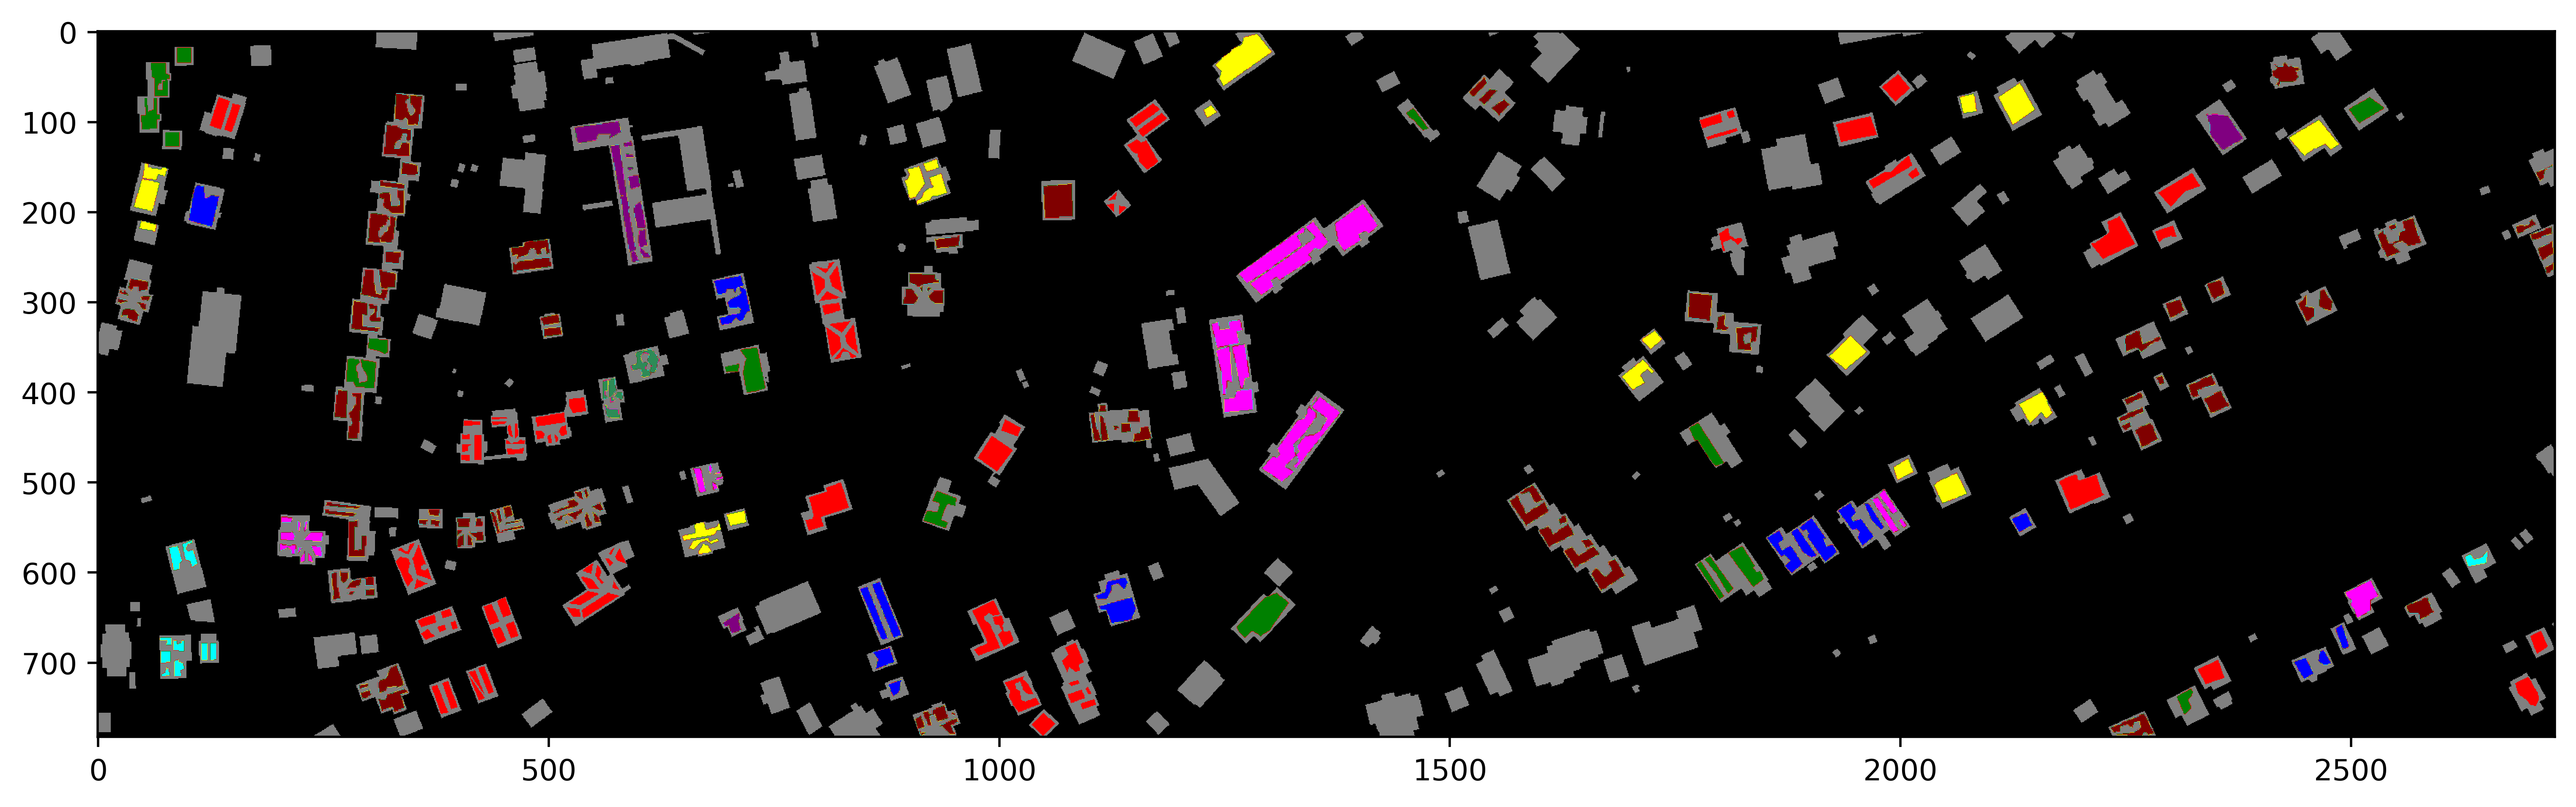

In [4]:
img = np.load("spectral_library/roof_map.npy")
classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pvc", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img, cmap=colormap)
plt.show()

## Watershed function

In [5]:
def water(img, threshold=0.7):
    ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY, 0)
    
    kernel = np.ones((2,2),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    
    opening = opening.astype(np.uint8)
    
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 3)
    ret, sure_fg = cv.threshold(dist_transform,threshold*dist_transform.max(),255,0)
    
    sure_bg = np.uint8(sure_bg)
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)
    
    ret, markers = cv.connectedComponents(sure_fg)
    markers = markers
    markers[unknown==255] = 0
    
    a = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    
    # Watershed
    #gray = np.uint8(gray)
    markers = cv.watershed(a,markers)
    return markers, a

## Fill in majority function

In [6]:
def fill_majority(markers, a):
    count = np.unique(markers, return_counts=True)
    most = count[0][count[1].argmax()]
    for i in range(1, np.unique(markers).max()+1):
        if i is not most:
            try:
                if np.bincount(a[markers==i][:,0]).shape[0] > 2:
                    # Then there is more than None and unknown in the object
                    most_off = np.bincount(a[markers==i][:,0]).argmax()
                    if most_off == 1:
                        # Pick out second most
                        l = np.argsort(np.bincount(a[markers==i][:,0]))[-2]
                        a[markers == i] = l
                    else:
                        a[markers == i] = most_off
                    
                else:
                    most_off = np.bincount(a[markers==i][:,0]).argmax()
                    a[markers == i] = most_off
            except:
                pass
    
    b = a.astype(int)
    b = b[:,:,0] -1 
    b[markers == -1] = -1
    
    return b, most

## Apply algorithms

In [7]:
img = np.uint8(img)
temp_img1, temp_img2, temp_img3 = None,None,None

markers, a = water(img, threshold=0.6)
b, most = fill_majority(markers, a)
temp_img1 = b.copy()
final_img = b
img[markers!=most] = 0

markers, a = water(img, threshold=0.5)
b, most = fill_majority(markers, a)
temp_img2 = b.copy()
final_img[b>-1] = b[b>-1]
img[markers!=most] = 0

markers, a = water(img, threshold=0.3)
b, most = fill_majority(markers, a)
temp_img3 = b.copy()
final_img[b>-1] = b[b>-1]
img[markers!=most] = 0

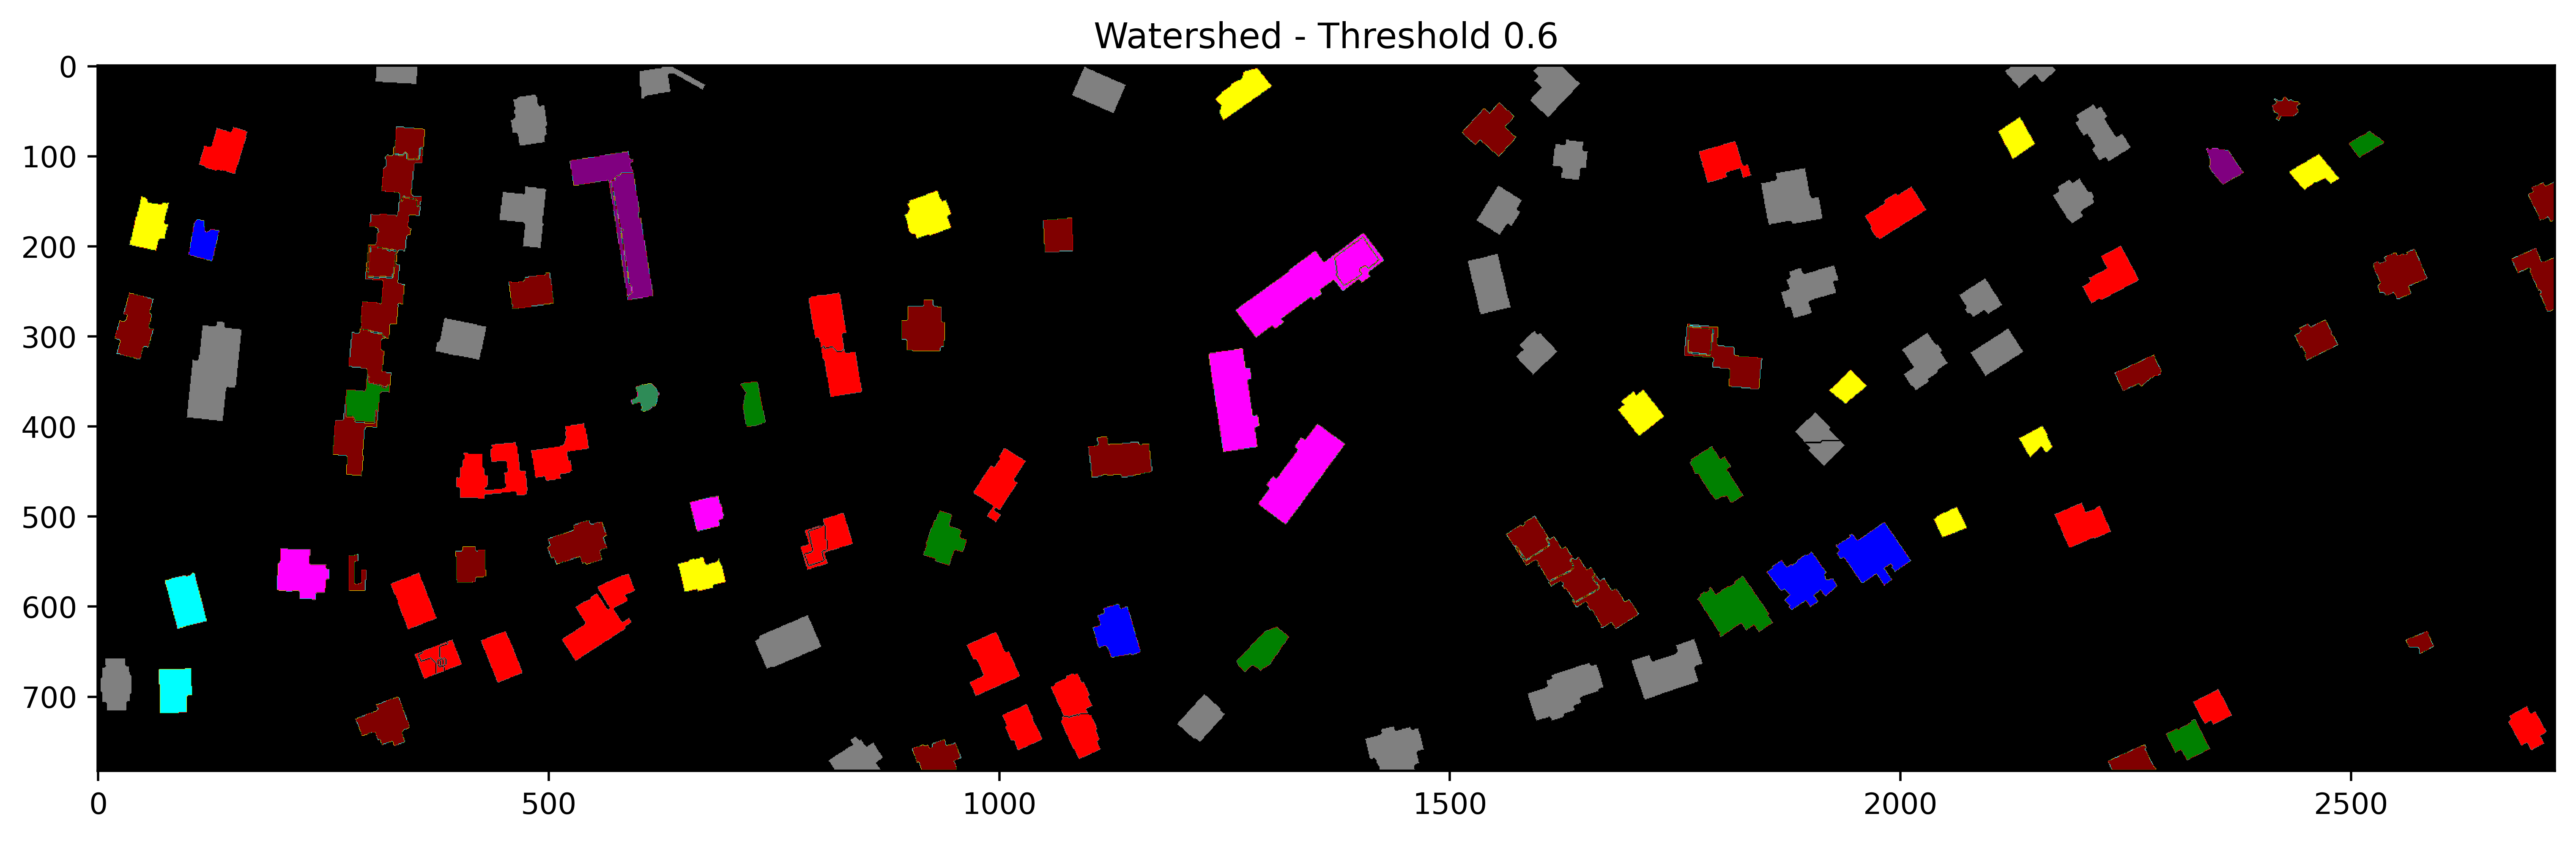

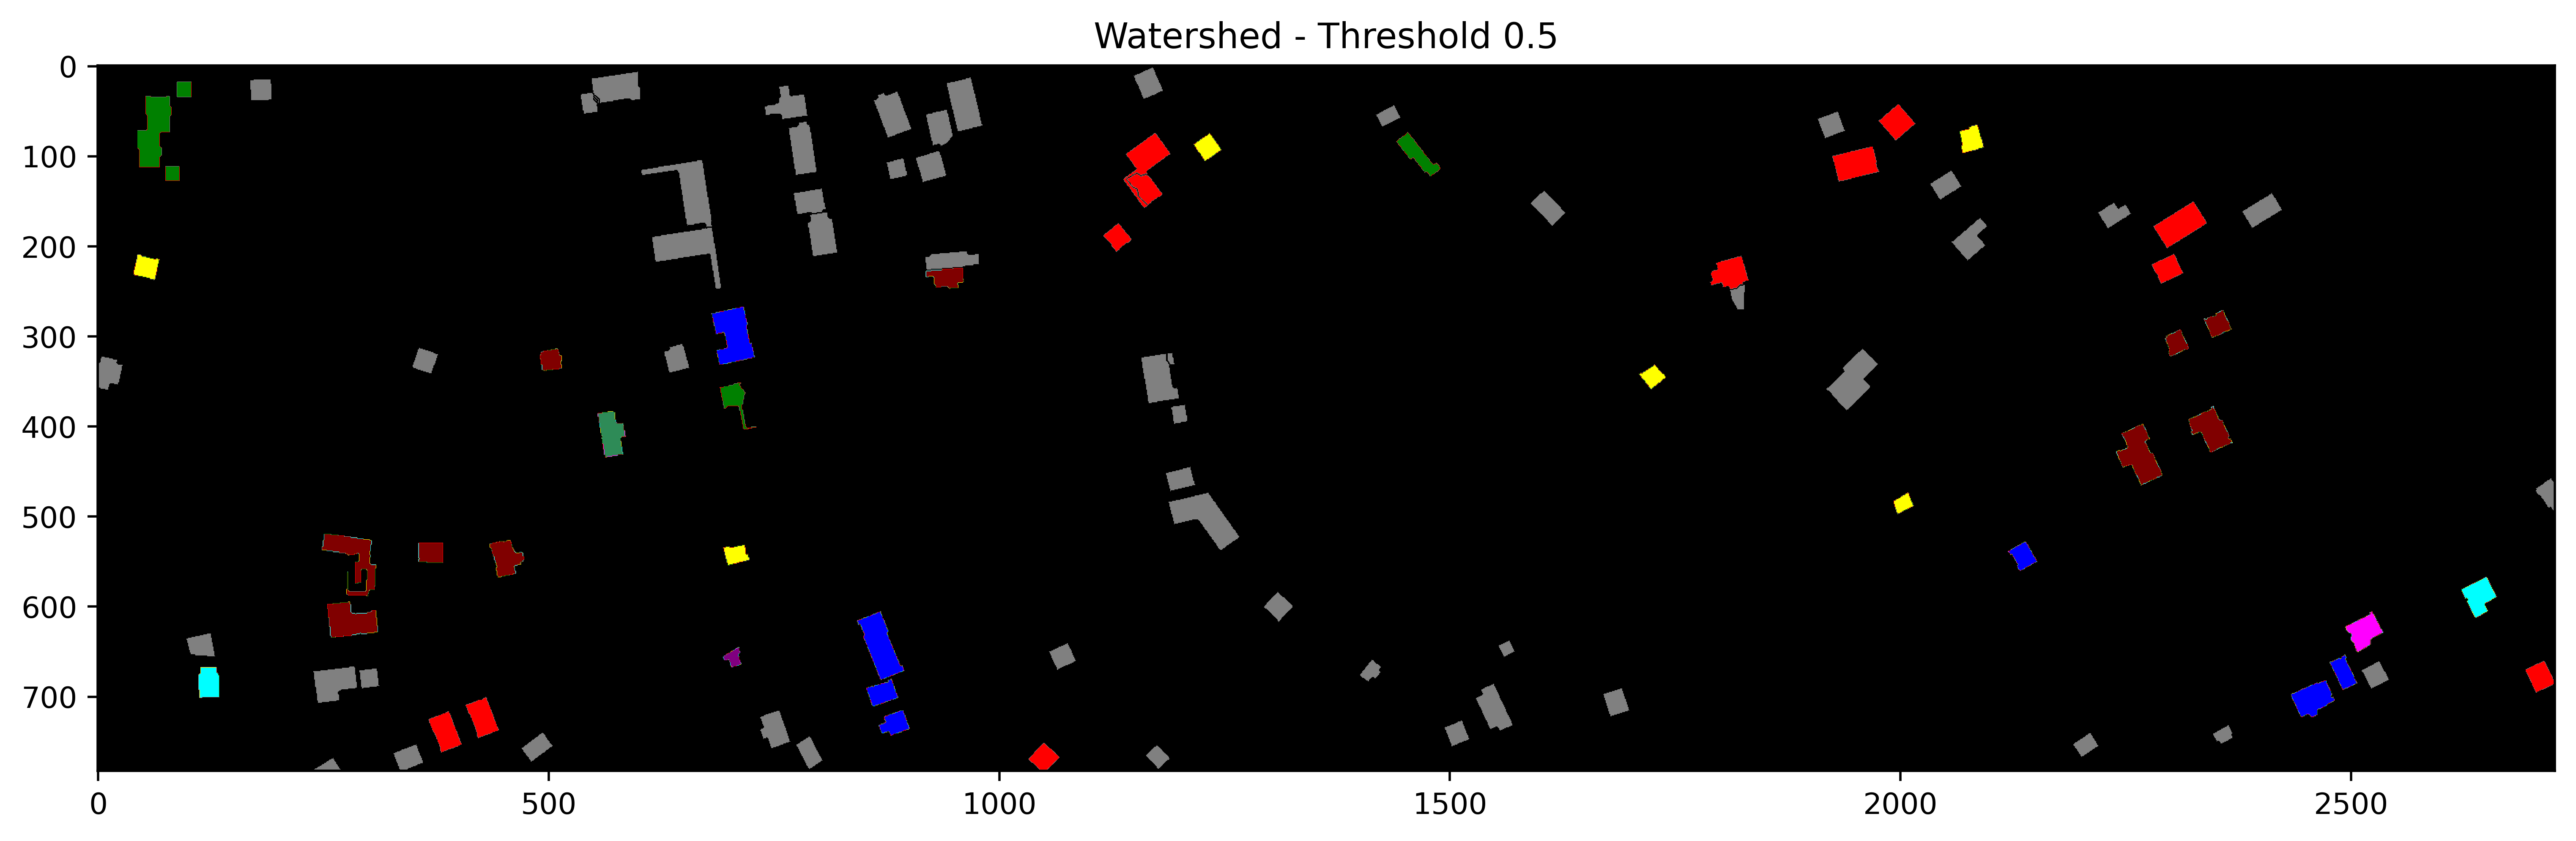

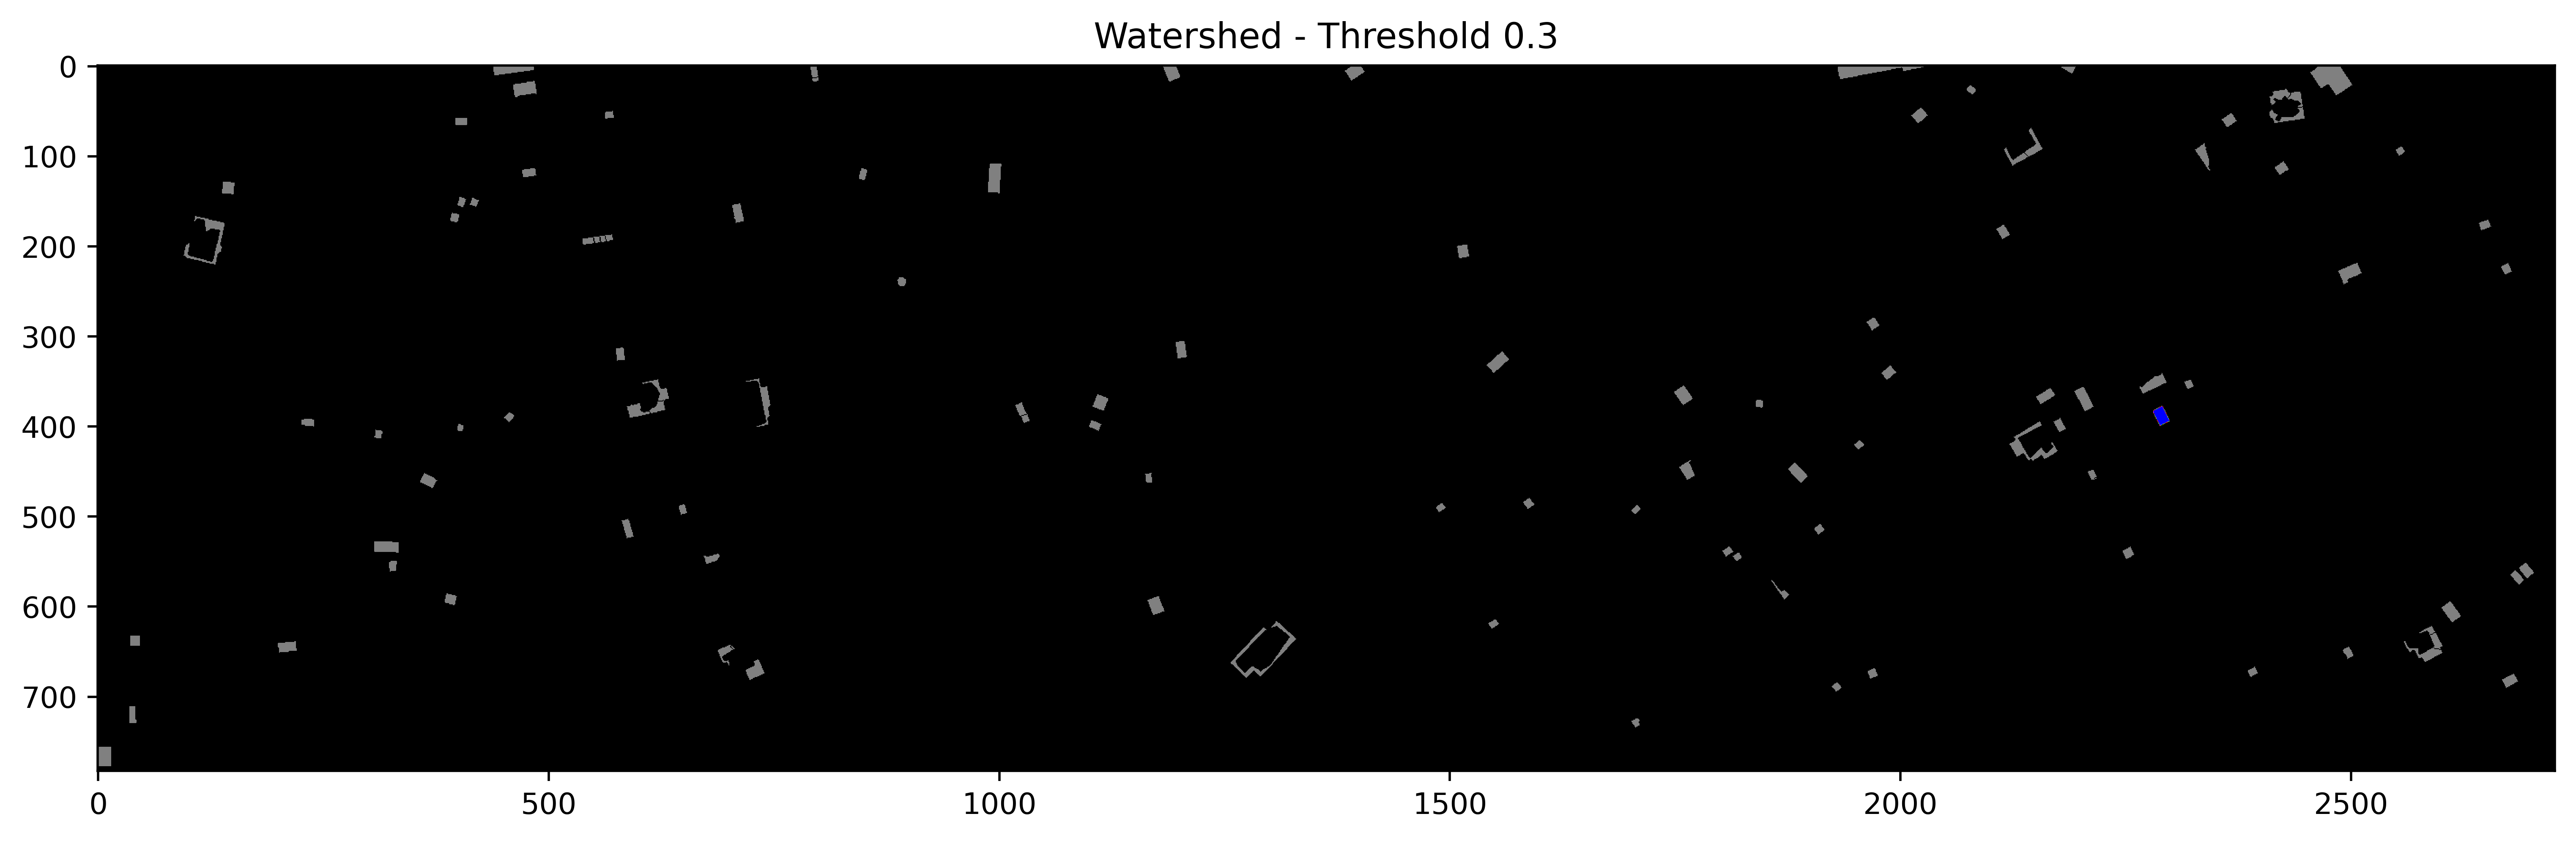

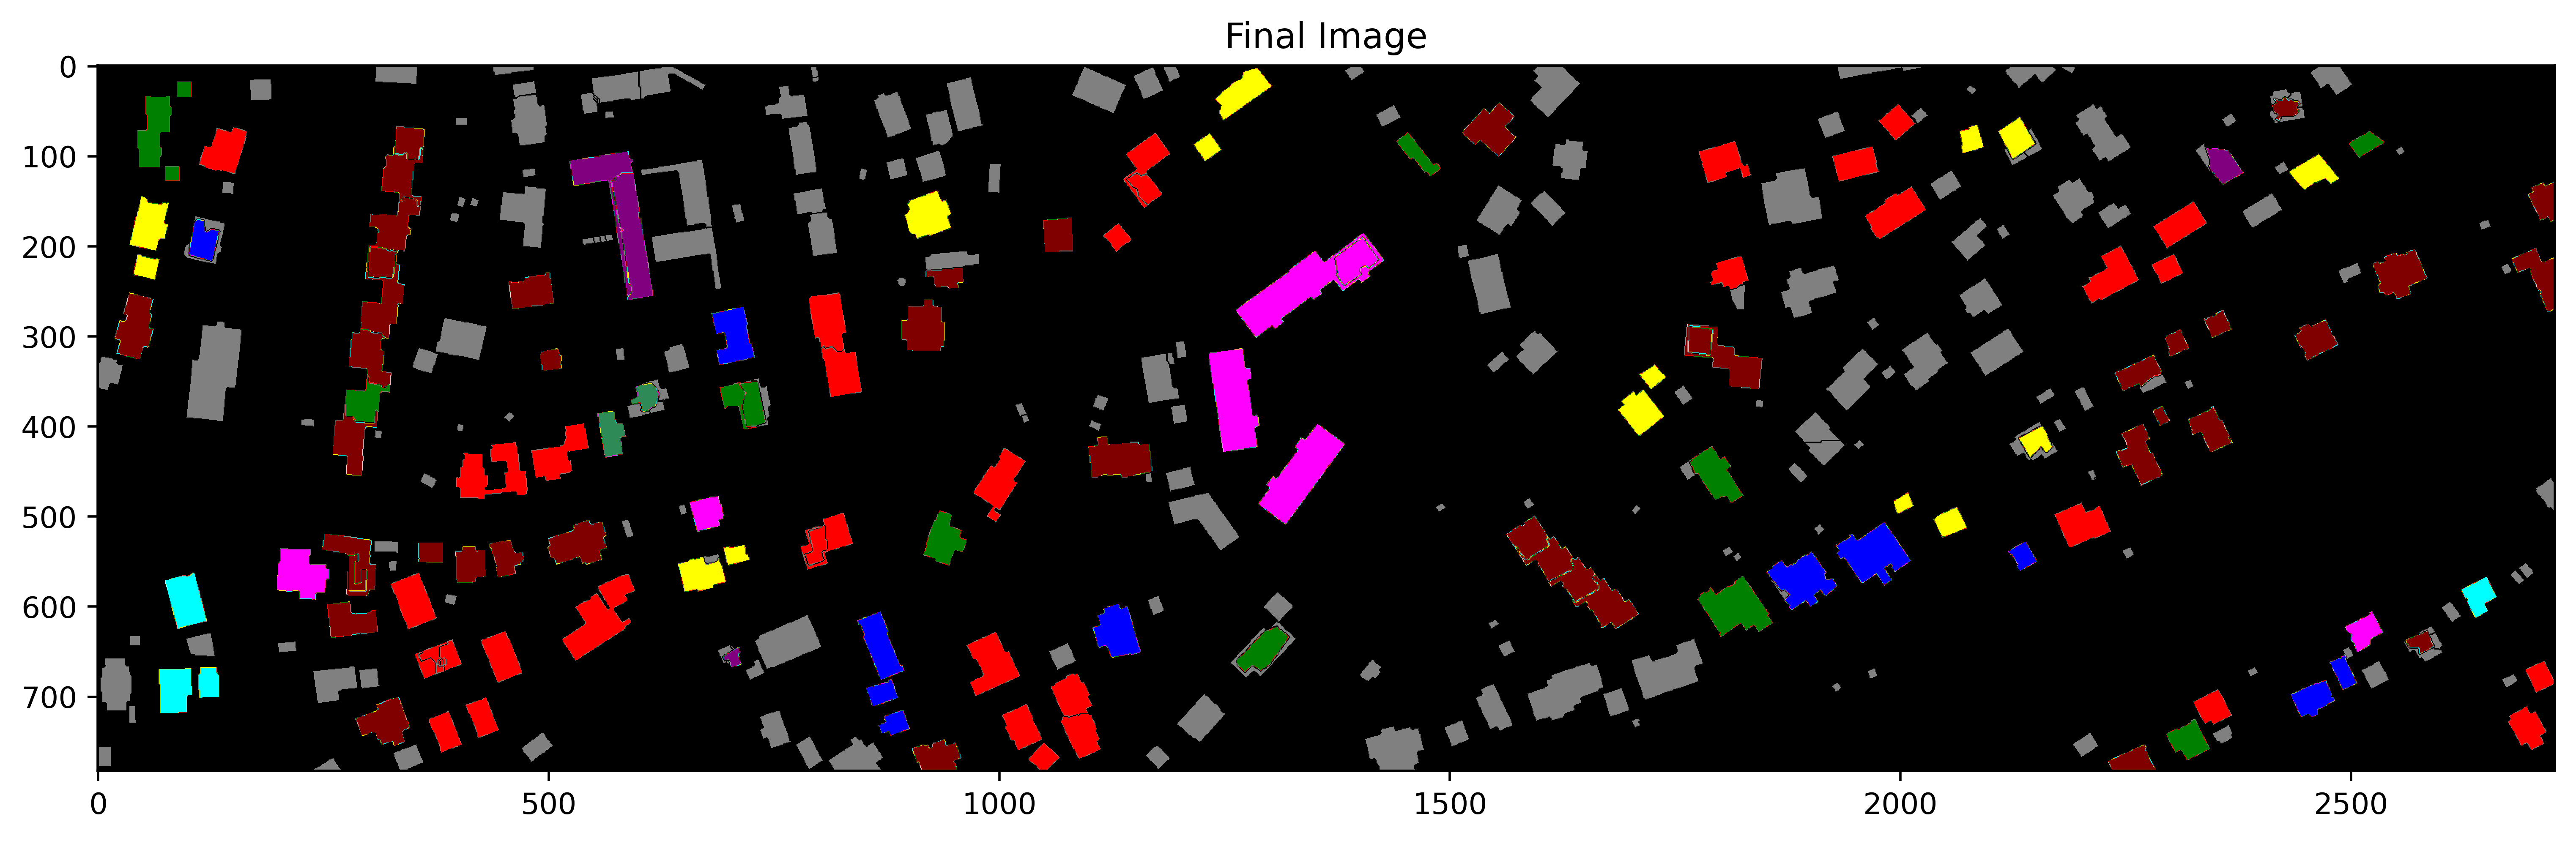

In [8]:
for i,name in [(temp_img1+1, 'Watershed - Threshold 0.6'), 
                (temp_img2+1, 'Watershed - Threshold 0.5'),
                (temp_img3+1, 'Watershed - Threshold 0.3'),
                (final_img+1, 'Final Image')]:
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(i, cmap=colormap)
    plt.title(name)
    plt.show()

# Change gravel class to red concrete
I don't think it is gravel

In [9]:
final_img[final_img == 6] = 5

classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "green ceramic", "pvc", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                            "seagreen", "purple", "blue"])

In [10]:
final_img[final_img == 7] = 6
final_img[final_img == 8] = 7
final_img[final_img == 9] = 8 

# Final ground truth

In [11]:
np.unique(final_img)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

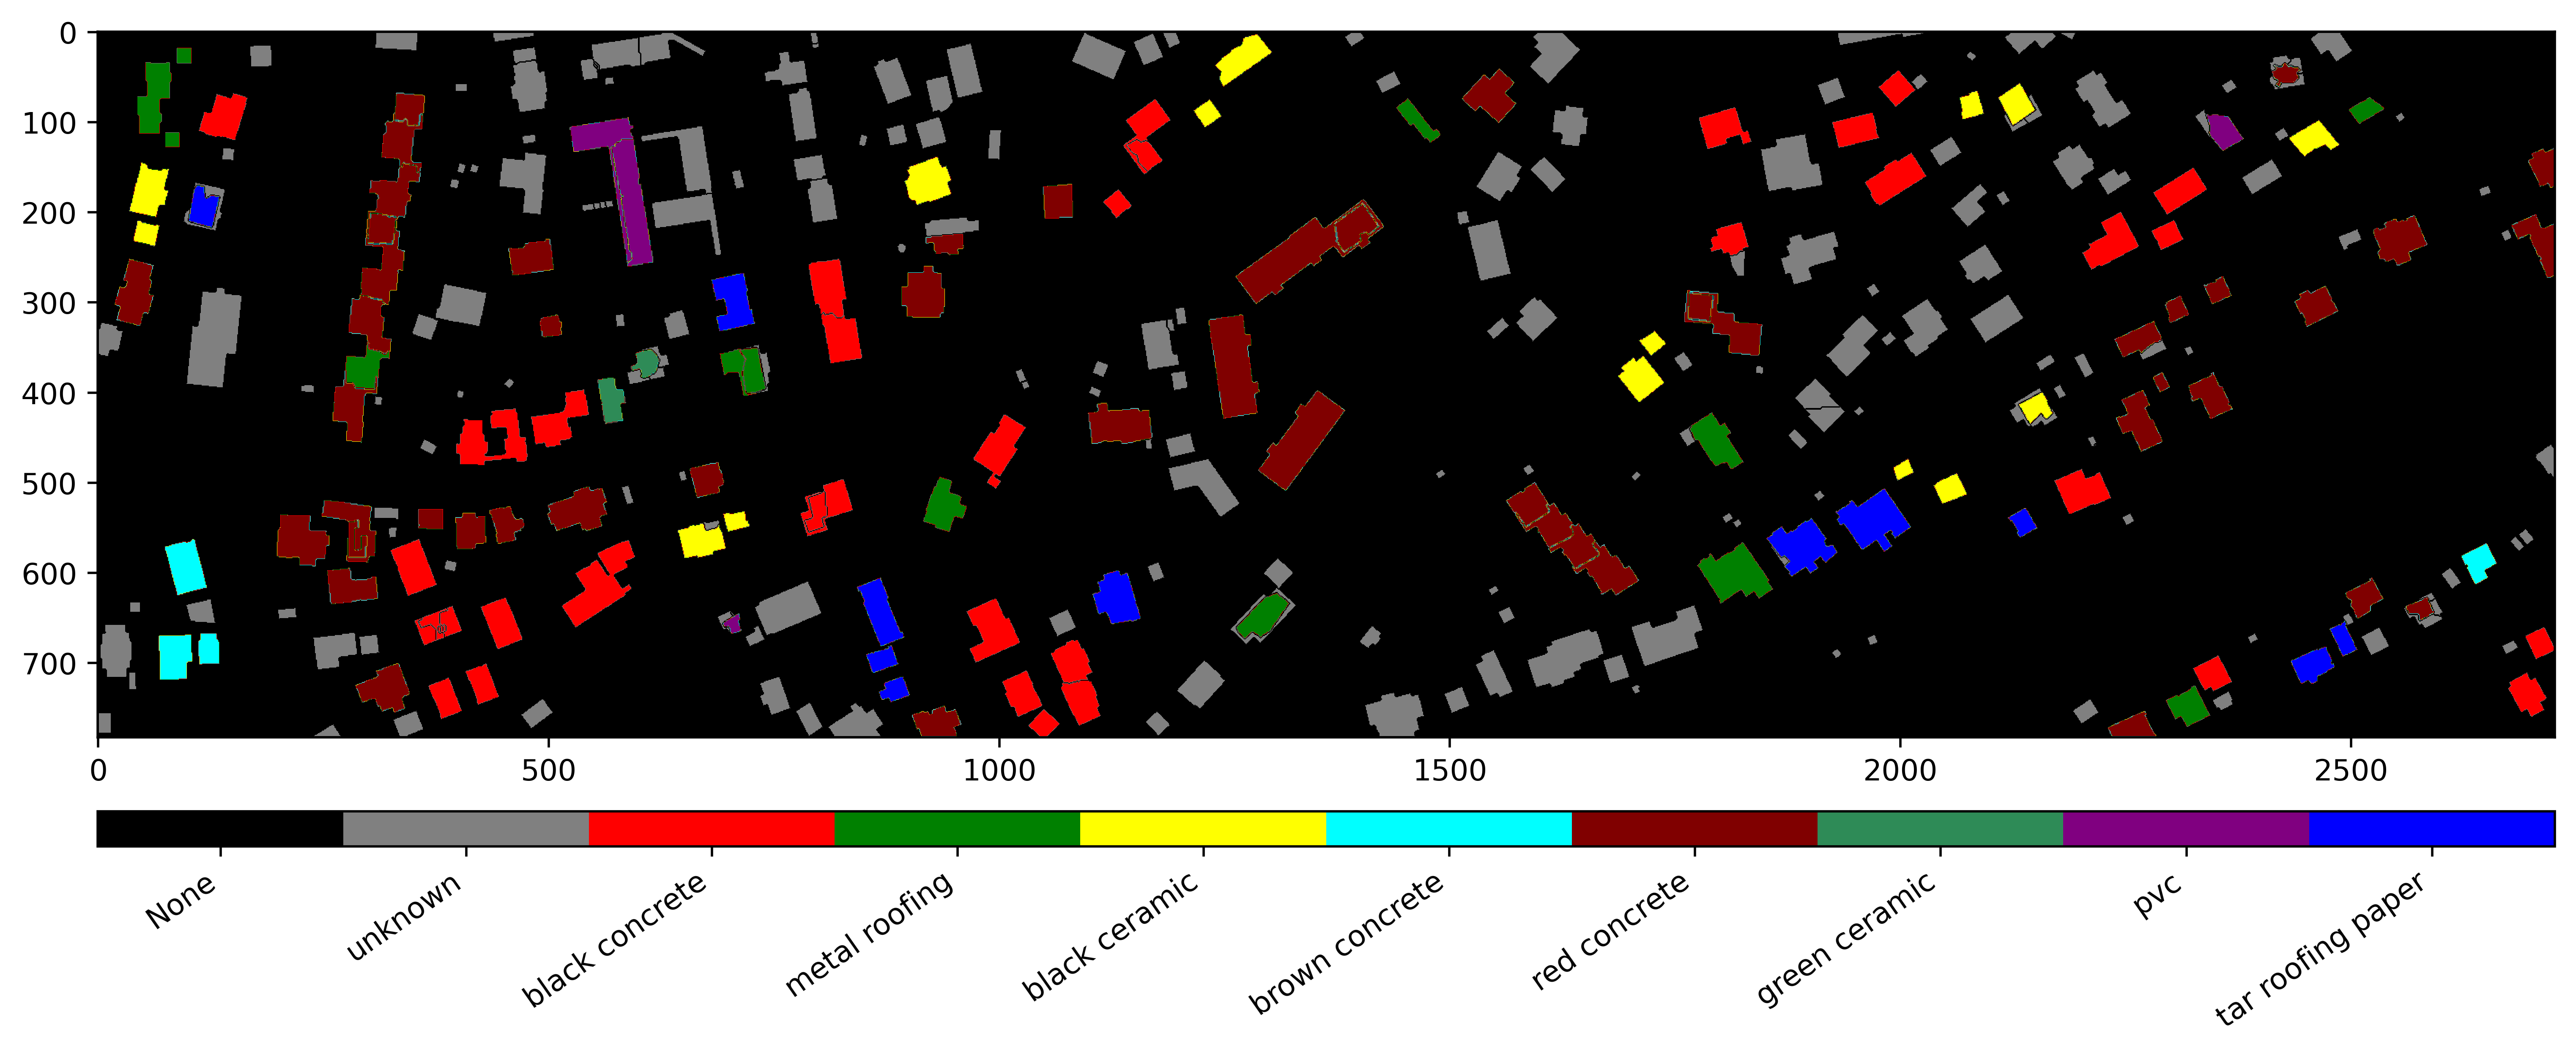

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(final_img+1, cmap=colormap)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
   
cbar = plt.colorbar(im, orientation='horizontal', cax=cax)

n_clusters = 10
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

# set tick labels (as before)

cbar.ax.set_xticklabels(classes, rotation=35, ha='right')

plt.show()

In [42]:
np.save("spectral_library/label.npy", final_img)